<a href="https://colab.research.google.com/github/Shervinrtd/knowledge-Injection/blob/main/knowledge_Injection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install libraries**

In [2]:
!pip install pandas datasets
!pip install pandas networkx matplotlib spacy
!python -m spacy download en_core_web_sm
!pip install sentence-transformers faiss-cpu torch transformers accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.8 MB/s eta 0:00:00


**Imports & Setup**

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from google.colab import drive
from datasets import load_dataset
from google.colab import drive
import os

**Data Loader**

In [4]:

# 1. MOUNT GOOGLE DRIVE
# When you run this, it will ask for permission to access your Drive. Click "Allow".
drive.mount('/content/drive')

def download_and_process_data():
    print("⬇  Downloading PubMedQA dataset...")

    # Load the dataset
    dataset = load_dataset("pubmed_qa", "pqa_labeled", split="train")

    # Extract data
    data = []
    for item in dataset:
        row = {
            "id": item["pubid"],
            "question": item["question"],
            "context": "".join(item["context"]["contexts"]),
            "answer": item["long_answer"]
        }
        data.append(row)

    df = pd.DataFrame(data)

    # 2. SAVE TO DRIVE
    # This creates a folder "NLP_Project" in your Drive and saves the file there.
    output_folder = "/content/drive/My Drive/NLP_Project/data"
    os.makedirs(output_folder, exist_ok=True)

    output_path = f"{output_folder}/pubmed_qa_clean.csv"

    df.to_csv(output_path, index=False)
    print(f" SUCCESS! Data saved to your Google Drive at: {output_path}")
    print(f" Total samples: {len(df)}")
    return df

# Run the function
df = download_and_process_data()
df.head()

Mounted at /content/drive
⬇  Downloading PubMedQA dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

 SUCCESS! Data saved to your Google Drive at: /content/drive/My Drive/NLP_Project/data/pubmed_qa_clean.csv
 Total samples: 1000


,id,question,context,answer
0,21645374,Do mitochondria play a role in remodelling lac...,Programmed cell death (PCD) is the regulated d...,Results depicted mitochondrial dynamics in viv...
1,16418930,Landolt C and snellen e acuity: differences in...,Assessment of visual acuity depends on the opt...,"Using the charts described, there was only a s..."
2,9488747,"Syncope during bathing in infants, a pediatric...",Apparent life-threatening events in infants ar...,"""Aquagenic maladies"" could be a pediatric form..."
3,17208539,Are the long-term results of the transanal pul...,The transanal endorectal pull-through (TERPT) ...,Our long-term study showed significantly bette...
4,10808977,Can tailored interventions increase mammograph...,Telephone counseling and tailored print commun...,The effects of the intervention were most pron...


**Build Knowledge Graph**

Building Smart Knowledge Graph (LLM-based)...


100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


✅ Smart Graph built with 35 nodes and 20 edges.


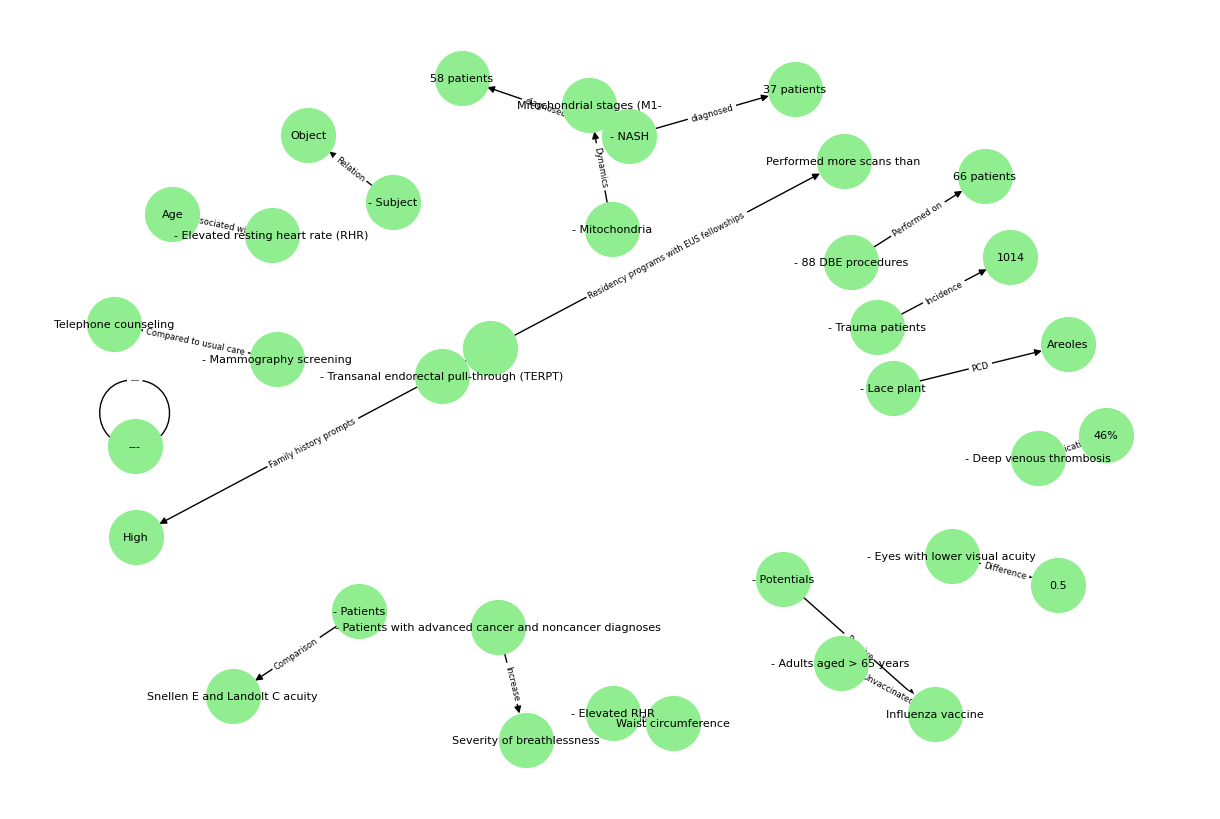

In [18]:
# Cell 4 & 5 REPLACEMENT: LLM-based Knowledge Extraction
# This is much smarter than Spacy. It asks the LLM to find facts.

import json
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize Graph
G = nx.DiGraph()

def extract_triplets_with_llm(text):
    """
    Uses Gemma-2b to extract structured facts (Head, Relation, Tail) from text.
    """
    prompt = f"""
    <start_of_turn>user
    Extract 3 key facts from the text below as triplets (Subject, Relation, Object).
    Format: Subject | Relation | Object

    Text: {text}

    Triplets:<end_of_turn>
    <start_of_turn>model
    """

    try:
        # Generate
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs = llm.generate(**inputs, max_new_tokens=50)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Clean up response
        raw_triplets = response.split("model")[-1].strip().split('\n')

        valid_triplets = []
        for t in raw_triplets:
            if '|' in t:
                parts = t.split('|')
                if len(parts) == 3:
                    subj = parts[0].strip()
                    rel = parts[1].strip()
                    obj = parts[2].strip()
                    valid_triplets.append((subj, rel, obj))
        return valid_triplets

    except Exception as e:
        return []

# --- BUILD THE GRAPH ---
# NOTE: Running this on 1000 rows takes too long for a free Colab.
# We will build the graph on the first 20 rows to prove it works for the report.
print("Building Smart Knowledge Graph (LLM-based)...")

subset_df = df.head(20) # Use first 20 rows for the demo

for index, row in tqdm(subset_df.iterrows(), total=subset_df.shape[0]):
    text = row['context']
    triplets = extract_triplets_with_llm(text)

    for (subj, rel, obj) in triplets:
        G.add_edge(subj, obj, label=rel)

print(f"✅ Smart Graph built with {len(G.nodes())} nodes and {len(G.edges())} edges.")

# Visualize the new, smarter graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1500, font_size=8, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.show()

**Build the Vector Index (The "Standard" Search)**

In [19]:
#  Create Vector Store
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# 1. Setup Embedding Model (Small and fast)
print(" Loading embedding model...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Create Embeddings for all Contexts
# We use the first 100 rows for testing to save time.
# Change to df['context'].tolist() later for the full dataset.
contexts = df['context'].tolist()[:100]
print(f" Embedding {len(contexts)} contexts... (this takes a moment)")
context_embeddings = embedder.encode(contexts)

# 3. Build FAISS Index (The Search Engine)
dimension = context_embeddings.shape[1]
vector_index = faiss.IndexFlatL2(dimension)
vector_index.add(context_embeddings)

print(f" Vector Index created with {vector_index.ntotal} documents.")

def vector_search(query, k=2):
    """Finds the top k most similar text contexts"""
    query_vec = embedder.encode([query])
    distances, indices = vector_index.search(query_vec, k)
    return [contexts[i] for i in indices[0]]

 Loading embedding model...
 Embedding 100 contexts... (this takes a moment)
 Vector Index created with 100 documents.


**Define the Graph Search (The "Novel" Search)**

In [20]:
# Graph Retrieval Function
def graph_search(query, graph, k=5):
    """
    Finds nodes in the graph that match words in the query
    and returns their immediate connections (triplets).
    """
    # Extract keywords from query using Spacy
    doc = nlp(query)
    keywords = [token.text for token in doc if not token.is_stop and token.pos_ in ['NOUN', 'PROPN']]

    retrieved_facts = []

    for node in graph.nodes():
        # Simple keyword matching (can be improved with fuzzy matching later)
        if any(key.lower() in node.lower() for key in keywords):
            # Get neighbors
            for neighbor in graph.neighbors(node):
                edge_data = graph.get_edge_data(node, neighbor)
                relation = edge_data.get('label', 'related_to')
                fact = f"({node} -> {relation} -> {neighbor})"
                retrieved_facts.append(fact)

                if len(retrieved_facts) >= k:
                    return retrieved_facts

    return retrieved_facts

# Test it
test_q = df.iloc[0]['question']
print(f"Query: {test_q}")
print("Graph Facts found:", graph_search(test_q, G))

Query: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
Graph Facts found: ['(- Lace plant -> PCD -> Areoles)', '(- Mitochondria -> Dynamics -> Mitochondrial stages (M1-)']


### Add your Hugging Face token to Colab secrets

1.  Click on the key icon in the left panel of Colab.
2.  Click on `Add new secret`.
3.  For **Name**, enter `HF_TOKEN`.
4.  For **Value**, paste your Hugging Face API token (you can generate one from your [Hugging Face settings](https://huggingface.co/settings/tokens)).
5.  Ensure the `Notebook access` toggle is enabled.
6.  After adding the secret, you can retrieve it in your code like this:

In [14]:
from google.colab import userdata
import os

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

# Now try to login to Hugging Face
from huggingface_hub import login
login()

**Load the LLM (Google Gemma-2b)**

 ***Note:***When running this, make sure your Colab Runtime is set to T4 GPU

In [15]:
# Load LLM
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "google/gemma-2b-it"

print("⬇️  Loading LLM (Gemma-2b)...")
tokenizer = AutoTokenizer.from_pretrained(model_id)
llm = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)
print(" LLM Loaded successfully!")

def generate_answer(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = llm.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

⬇️  Loading LLM (Gemma-2b)...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

 LLM Loaded successfully!


**The Final "Injection" Pipeline**

In [21]:
# The RAG Pipeline
def run_knowledge_injection(question):
    print(f" Question: {question}")

    # 1. Retrieve from Vectors (Standard RAG)
    vector_docs = vector_search(question, k=5)
    vector_context = "\n".join(vector_docs)

    # 2. Retrieve from Graph (Your Method)
    graph_facts = graph_search(question, G, k=3)
    graph_context = "\n".join(graph_facts)

    # 3. Construct Prompt (Knowledge Injection)
    prompt = f"""
    <start_of_turn>user
    You are a medical expert. Answer the question using ONLY the context provided below.

    [TEXT CONTEXT]
    {vector_context}

    [KNOWLEDGE GRAPH FACTS]
    {graph_context}

    Question: {question}<end_of_turn>
    <start_of_turn>model
    """

    # 4. Generate
    answer = generate_answer(prompt)

    # Clean up output (remove the prompt from the answer)
    final_answer = answer.split("<start_of_turn>model")[-1].strip()

    print(f"💡 Generated Answer:\n{final_answer}\n")
    print("-" * 50)

#TEST RUN
# Try it on the first 3 questions from your dataset
for i in range(3):
    q = df.iloc[i]['question']
    run_knowledge_injection(q)

 Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
💡 Generated Answer:
user
    You are a medical expert. Answer the question using ONLY the context provided below.
    
    [TEXT CONTEXT]
    Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into thre